### Basic setup 

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install nnsight transformers
!pip install transformer_lens
!pip install -q --upgrade torch torchvision
!pip install seaborn
!pip install matplotlib

Found existing installation: torch 2.4.1+cu124
Uninstalling torch-2.4.1+cu124:
  Successfully uninstalled torch-2.4.1+cu124
Found existing installation: torchvision 0.19.1+cu124
Uninstalling torchvision-0.19.1+cu124:
  Successfully uninstalled torchvision-0.19.1+cu124
Found existing installation: torchaudio 2.4.1+cu124
Uninstalling torchaudio-2.4.1+cu124:
  Successfully uninstalled torchaudio-2.4.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 59.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 34.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torchvision
print(f"Torch: {torch.__version__}")
print(f"TorchVision: {torchvision.__version__}")

# If this works, your main script will work
from transformers import PreTrainedModel
print("Success: Transformers loaded correctly.")

Torch: 2.9.1+cu128
TorchVision: 0.24.1+cu128
Success: Transformers loaded correctly.


In [3]:
# 1. Clean up old attempts (optional, just to be safe)
!rm -rf temp_repo repository circuit_tracer graph_visualization.py

# 2. Clone the repo "lightweight" (depth=1 means no history, very fast)
print("Downloading repo...")
!git clone --depth 1 https://github.com/safety-research/circuit-tracer temp_repo

# 3. Move ONLY the files we need to the main folder
print("Extracting core files...")
# Move the library folder
!mv temp_repo/circuit_tracer .
# Move the visualization tool (it lives in demos/ originally)
!mv temp_repo/demos/graph_visualization.py .

# 4. Delete the rest of the heavy repository
print("Cleaning up...")
!rm -rf temp_repo

# 5. Install the library dependencies
print("Installing dependencies...")
!pip install -q -e circuit_tracer/

print("Done! You now have a slim setup.")

Cloning into 'temp_repo'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 118 (delta 4), reused 63 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (118/118), 2.14 MiB | 4.43 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (97/97), done.
Extracting core files...
Cleaning up...
Installing dependencies...

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
ERROR: file:///workspace/MATS-proposal/circuit_tracer does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Done! You now have a slim setup.


In [4]:
# 1. Standard Library Imports
import os
import shutil
import copy
from collections import namedtuple
from typing import List, Dict

# 2. Third-Party Imports (Torch, NumPy, Visualization)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from huggingface_hub import notebook_login

# 3. Local Application Imports
from circuit_tracer import ReplacementModel
from circuit_tracer.utils.decode_url_features import decode_url_features
from graph_visualization import (
    create_graph_visualization, 
    Supernode, 
    InterventionGraph, 
    Feature
)

### Loading the model

In [5]:
print("Loading Model...")
model = ReplacementModel.from_pretrained(
    "google/gemma-2-2b", 
    'gemma', 
    dtype=torch.bfloat16
)
print("Ready to trace!")

Loading Model...


config.yaml: 0.00B [00:00, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

layer_2/width_16k/average_l0_49/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_7/width_16k/average_l0_70/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_0/width_16k/average_l0_76/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_5/width_16k/average_l0_87/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_6/width_16k/average_l0_95/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_4/width_16k/average_l0_88/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_3/width_16k/average_l0_54/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_1/width_16k/average_l0_65/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_8/width_16k/average_l0_52/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_9/width_16k/average_l0_72/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_10/width_16k/average_l0_88/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_12/width_16k/average_l0_6/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_11/width_16k/average_l0_5/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_13/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_14/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_15/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_16/width_16k/average_l0_10/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_17/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_18/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_19/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_20/width_16k/average_l0_11/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_21/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_22/width_16k/average_l0_15/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_23/width_16k/average_l0_25/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_24/width_16k/average_l0_37/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_25/width_16k/average_l0_41/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer
Ready to trace!


### Extraction of Texas supernode from neuronpedia attribution graph

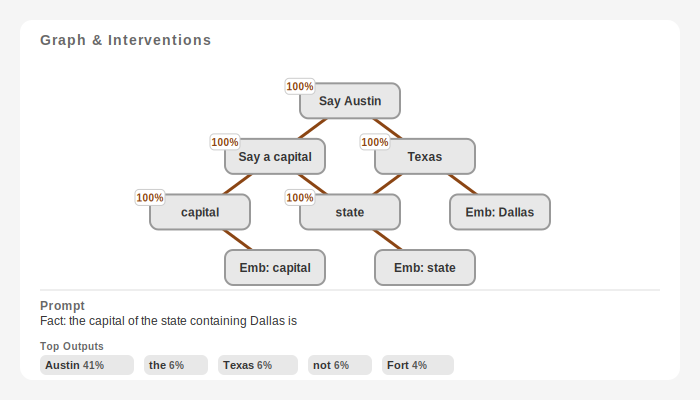

In [6]:

# 1. Define the Circuit URL (from the tutorial)
dallas_austin_url="https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&clerps=%5B%5D&pruningThreshold=0.53&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D"

# 2. Decode features from the URL
supernode_features, _ = decode_url_features(dallas_austin_url)

# 3. Create Supernodes (The Nodes of the Graph)
say_austin_node = Supernode(name='Say Austin', features=[Feature(layer=23, pos=10, feature_idx=12237)])
say_capital_node = Supernode(name='Say a capital', features=supernode_features['capital cities / say a capital city'], children=[say_austin_node])

# Intermediate nodes
texas_node = Supernode(name='Texas', features=supernode_features['Texas'], children=[say_austin_node])
state_node = Supernode(name='state', features=supernode_features['state'], children=[say_capital_node, texas_node])
capital_node = Supernode(name='capital', features=supernode_features['capital'], children=[say_capital_node])

# Embedding nodes
dallas_node = Supernode(name='Emb: Dallas', features=None, children=[texas_node])
state_emb_node = Supernode(name='Emb: state', features=None, children=[state_node])
capital_emb_node = Supernode(name='Emb: capital', features=None, children=[capital_node])

# 4. Initialize the Graph
prompt = "Fact: the capital of the state containing Dallas is"
ordered_nodes = [[capital_emb_node, state_emb_node],[capital_node, state_node, dallas_node],[say_capital_node, texas_node], [say_austin_node]]
dallas_austin_graph = InterventionGraph(ordered_nodes=ordered_nodes, prompt=prompt)

# 5. Run the model to get base activations
logits, dallas_activations = model.get_activations(prompt)

# Initialize nodes with base activations
for node in [capital_node, state_node, dallas_node, say_capital_node, texas_node, say_austin_node]:
    dallas_austin_graph.initialize_node(node, dallas_activations)  
dallas_austin_graph.set_node_activation_fractions(dallas_activations)  

# 6. Helper function to show output
def get_top_outputs(logits: torch.Tensor, k: int = 5):
    top_probs, top_token_ids = logits.squeeze(0)[-1].softmax(-1).topk(k)
    top_tokens = [model.tokenizer.decode(token_id) for token_id in top_token_ids]
    top_outputs = list(zip(top_tokens, top_probs.tolist()))
    return top_outputs

# 7. Visualize!
top_outputs = get_top_outputs(logits)
create_graph_visualization(dallas_austin_graph, top_outputs)

### Function for interventions

In [7]:

# Define a simple container for our interventions
Intervention = namedtuple('Intervention', ['supernode', 'scaling_factor'])

def supernode_intervention(intervention_graph: InterventionGraph, interventions: List[Intervention], replacements: Dict[str, Supernode] = None):
    """
    1. Applies the scaling factor to the specified supernodes.
    2. Runs the model again to get new activations.
    3. Updates the graph and visualizes the result.
    """
    # Calculate the new values for the intervened features
    intervention_values = []
    for intervened_supernode, scaling_factor in interventions:
        for feature, default_act in zip(intervened_supernode.features, intervened_supernode.default_activations):
            # New value = scaling_factor * original_value
            intervention_values.append((*feature, scaling_factor * default_act))
            
    # Run the model with these interventions
    new_logits, new_activations = model.feature_intervention(intervention_graph.prompt, intervention_values)
    
    # Update the graph with new data
    intervention_graph.set_node_activation_fractions(new_activations)
    top_outputs = get_top_outputs(new_logits)

    # Mark the nodes visually so we see what we changed
    for intervened_supernode, scaling_factor in interventions:
        intervened_supernode.activation = None # Reset specific activation display
        intervened_supernode.intervention = f'{scaling_factor}x' # Label it e.g. "-2x"

    # Handle replacement nodes (swapping Texas for California, etc.)
    if replacements is not None:
        for target, replacement in replacements.items():
            intervention_graph.nodes[target].replacement_node = replacement

    # Draw the new state
    return create_graph_visualization(intervention_graph, top_outputs)

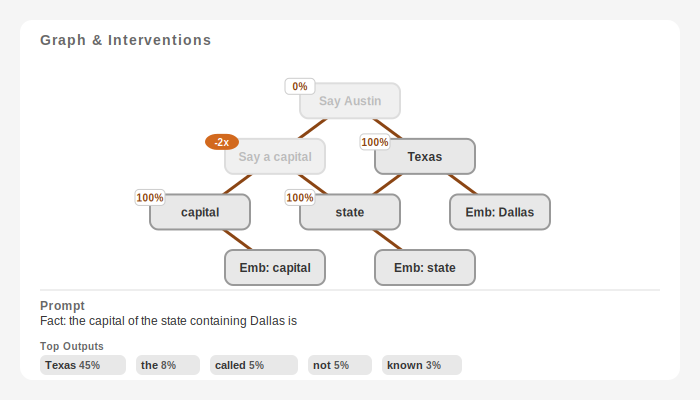

In [8]:
# Create the intervention: Scale "say_capital_node" by -2x
intervention = Intervention(say_capital_node, -2)

# Run it!
supernode_intervention(dallas_austin_graph, [intervention])

### Prediction on spelling task for Dallas after abalation
Turns out for Dallas prediction changes from D to a, after alpha >= -15

In [34]:
def test_spelling_ablation(target_word, original_supernode, scaling_factor=-2):
    # 1. Setup the Prompt
    prompt = f"The first letter of the word {target_word} is"
    print(f"\n--- Testing: '{prompt}' ---")
    
    # 2. FIND THE NEW POSITION
    # We need to find where 'target_word' is in this specific prompt
    # to apply the intervention at the right place.
    tokens = model.tokenizer.encode(prompt)
    
    # Simple search for the token index of the target word
    # (Note: This is a simple heuristic. For production, you'd match token IDs)
    target_pos_idx = -1
    
    # We look for the word (skipping the first few tokens of the prompt boilerplate)
    # The prompt structure is fixed: "The first letter in the word [TARGET] is"
    # "The"(0) " first"(1) " letter"(2) " in"(3) " the"(4) " word"(5) " [TARGET]"(6)
    # So the target is likely at index 6 or 7 depending on tokenization.
    
    # Let's verify by decoding
    for i, t in enumerate(tokens):
        decoded = model.tokenizer.decode([t]).strip()
        if target_word in decoded: # weak match
            target_pos_idx = i
            break
            
    if target_pos_idx == -1:
        print(f"Warning: Could not find '{target_word}' in tokens. Defaulting to last token - 1.")
        target_pos_idx = len(tokens) - 2

    print(f"Re-binding features to position {target_pos_idx} (Word: '{target_word}')")

    # 3. CREATE A NEW SUPERNODE ALIGNED TO THIS POSITION
    # We copy the features but update their '.pos' to the new index
    new_features = []
    for f in original_supernode.features:
        # Create new feature with updated position
        # Feature is usually (layer, pos, index)
        new_f = Feature(layer=f.layer, pos=target_pos_idx, feature_idx=f.feature_idx)
        new_features.append(new_f)
        
    # Create the new node object
    aligned_node = Supernode(
        name=f"{original_supernode.name} (Pos {target_pos_idx})", 
        features=new_features
    )

    # 4. Create Graph & Run Baseline
    spelling_graph = InterventionGraph(
        ordered_nodes=[[aligned_node]], 
        prompt=prompt
    )
    
    logits, activations = model.get_activations(prompt)
    spelling_graph.initialize_node(aligned_node, activations)
    
    # 5. Check Activation
    # If the node is "pure Texas", it might not even light up for "Apple"
    if aligned_node.default_activations is not None:
        avg_act = aligned_node.default_activations.mean().item()
        print(f"Node Activation at target: {avg_act:.4f}")
    
    # 6. Baseline Prediction
    base_probs = logits[0, -1].softmax(-1)
    base_top_id = base_probs.argmax().item()
    base_token = model.tokenizer.decode(base_top_id)
    base_prob = base_probs[base_top_id].item()
    
    print(f"Base Prediction:    '{base_token}' ({base_prob:.1%})")

    # 7. Apply Intervention
    print(f"Applying Intervention ({scaling_factor}x)...")
    
    intervention_values = []
    for feature, default_act in zip(aligned_node.features, aligned_node.default_activations):
        intervention_values.append((*feature, scaling_factor * default_act))
            
    new_logits, _ = model.feature_intervention(prompt, intervention_values)
    
    new_probs = new_logits[0, -1].softmax(-1)
    
    new_top_id = new_probs.argmax().item()
    new_token = model.tokenizer.decode(new_top_id)
    
    new_prob = new_probs[new_top_id].item()
    
    print(f"Ablated Prediction: '{new_token}' ({new_prob:.1%})")
    
    if base_token == new_token:
        print("Result: ROBUST (Spelling survived)")
    else:
        print("Result: BROKEN (Spelling changed)")

# --- RUN FIXED EXPERIMENTS ---

# 1. Test Dallas (Should target position ~6)
test_spelling_ablation("Dallas", texas_node, scaling_factor=-20)

# 2. Test Apple (Should target position ~6)
test_spelling_ablation("Apple", texas_node, scaling_factor=-20)


--- Testing: 'The first letter of the word Dallas is' ---
Re-binding features to position 7 (Word: 'Dallas')
Node Activation at target: 15.3750
Base Prediction:    ' D' (43.2%)
Applying Intervention (-20x)...
Ablated Prediction: ' a' (9.0%)
Result: BROKEN (Spelling changed)

--- Testing: 'The first letter of the word Apple is' ---
Re-binding features to position 7 (Word: 'Apple')
Node Activation at target: 0.0000
Base Prediction:    ' A' (40.0%)
Applying Intervention (-20x)...
Ablated Prediction: ' A' (40.0%)
Result: ROBUST (Spelling survived)


## Result: Impact of Texas Vector Ablation on Spelling Task of Texas and Non-Texas cities

Running Texas Cities...


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Running Control Words...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


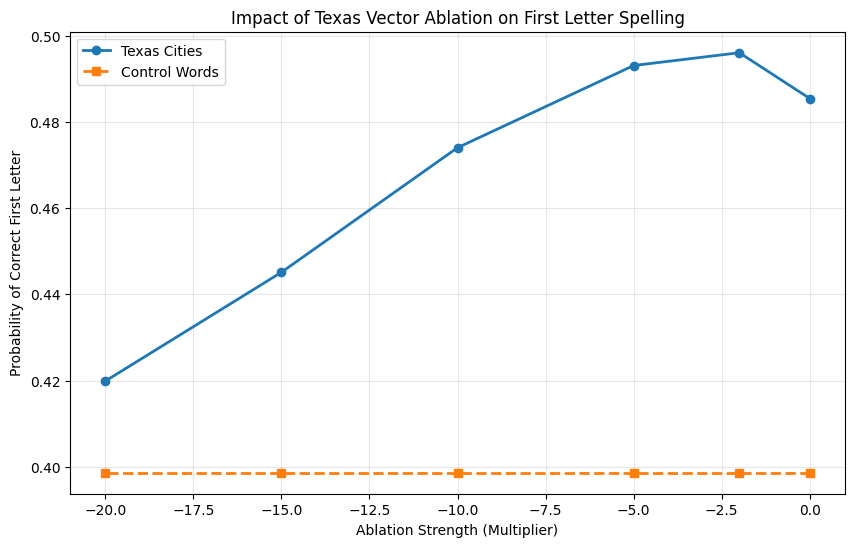

In [9]:
# --- 1. SETUP ---
# Reload Texas Node
dallas_austin_url="https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&clerps=%5B%5D&pruningThreshold=0.53&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D"
supernode_features, _ = decode_url_features(dallas_austin_url)
texas_node = Supernode(name='Texas', features=supernode_features['Texas'])

# Datasets

texas_cities = [
    "Dallas", "Houston", "Austin", "San Antonio", "El Paso", "Fort Worth", "Arlington", "Corpus Christi", "Plano", "Lubbock",
    "Laredo", "Irving", "Garland", "Frisco", "Amarillo", "Brownsville", "Waco", "Tyler", "Odessa", "Midland",
    "Abilene", "Beaumont", "Denton", "McAllen", "Killeen", "Pasadena", "Mesquite", "Galveston", "Victoria", "Wichita Falls",
    "Mission", "Pharr", "Harlingen", "Sugar Land", "Pearland", "San Angelo", "Lewisville", "Richardson", "Round Rock", "College Station",
    "League City", "Allen", "Edinburg", "Bryan", "Baytown", "Longview", "Flower Mound", "Missouri City", "North Richland Hills", "Mansfield"
]

control_words = [
    "Chicago", "New York", "Los Angeles", "Miami", "Seattle", "Denver", "Boston", "Atlanta", "Phoenix", "Detroit",
    "London", "Paris", "Tokyo", "Berlin", "Rome", "Madrid", "Beijing", "Moscow", "Cairo", "Sydney",
    "Toronto", "Mumbai", "Dubai", "Seoul", "Bangkok", "Lima", "Bogota", "Jakarta", "Istanbul", "Karachi",
    "Dhaka", "Shanghai", "Sao Paulo", "Mexico City", "Lagos", "Delhi", "Manila", "Tianjin", "Kinshasa", "Lahore",
    "Rio de Janeiro", "Shenzhen", "Bangalore", "Chennai", "Kolkata", "Nanjing", "Wuhan", "Hangzhou", "Chongqing", "Chengdu"
]

alphas = [0, -2, -5, -10, -15, -20]

# --- 2. CORRECTED FUNCTION ---

def run_robust_experiment(word_list, alphas, label):
    # Prepare to store results
    results = {alpha: [] for alpha in alphas}
    
    # We strip the position info from the original node features
    # because 'pos' changes with every new sentence
    texas_components = [(f.layer, f.feature_idx) for f in texas_node.features]

    print(f"Running {label}...")
    
    for word in tqdm(word_list):
        prompt = f"The first letter in the word {word} is"
        target_char = " " + word[0].upper()
        target_id = model.tokenizer.encode(target_char, add_special_tokens=False)[0]
        
        # 1. Trace the model to get REAL activations for this prompt
        # We need this to know what '1x' activation looks like so we can scale it
        logits_base, activations_dict = model.get_activations(prompt)
        
        # Find word position
        tokens = model.tokenizer.encode(prompt)
        word_pos_idx = -1
        for i, t in enumerate(tokens):
             if i < 4: continue 
             if word.lower() in model.tokenizer.decode([t]).lower():
                 word_pos_idx = i
                 break
        if word_pos_idx == -1: word_pos_idx = len(tokens) - 2 

        # 2. Extract the base values for our features at this position
        # activations_dict is a dictionary where keys are Feature(layer, pos, idx)
        # We construct the keys we expect to find
        current_feature_values = []
        for layer, idx in texas_components:
            key = Feature(layer=layer, pos=word_pos_idx, feature_idx=idx)
            pass

       
        # Create a temp node for this word position
        temp_features = [Feature(layer=l, pos=word_pos_idx, feature_idx=i) for l, i in texas_components]
        temp_node = Supernode("TempTexas", temp_features)
        
        # Initialize graph wrapper
        # We need to pass a list of lists of nodes (layers)
        from graph_visualization import InterventionGraph
        temp_graph = InterventionGraph([[temp_node]], prompt)
        
        # Initialize with the activations we got
        # This function internally handles the "Tensor vs Dict" logic for us
        temp_graph.initialize_node(temp_node, activations_dict)
        
        # Now temp_node.default_activations contains the REAL values for this prompt!
        
        # 3. Loop Alphas
        for alpha in alphas:
            if alpha == 0:
                prob = logits_base[0, -1].softmax(-1)[target_id].item()
                results[alpha].append(prob)
                continue
                
            # Construct Intervention List
            intervention_values = []
            
            # Iterate through the features we just initialized
            if temp_node.default_activations is not None:
                for feature, base_val in zip(temp_node.features, temp_node.default_activations):
                    # Scaling: new = alpha * old
                    # (Note: Use alpha directly as a multiplier. If you want ablation (removal), alpha=0.
                    # But your list is [-2, -5]. This implies "Invert and amplify".
                    # If you meant "Remove", use alpha=0. But let's stick to your list.)
                    new_val = alpha * base_val 
                    intervention_values.append((*feature, new_val))
            
            if not intervention_values:
                 prob = logits_base[0, -1].softmax(-1)[target_id].item()
            else:
                 logits_new, _ = model.feature_intervention(prompt, intervention_values)
                 prob = logits_new[0, -1].softmax(-1)[target_id].item()
            
            results[alpha].append(prob)

    return [np.mean(results[a]) for a in alphas]

# --- 3. RUN ---
texas_probs = run_robust_experiment(texas_cities, alphas, "Texas Cities")
control_probs = run_robust_experiment(control_words, alphas, "Control Words")

# --- 4. PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(alphas, texas_probs, 'o-', label='Texas Cities', linewidth=2)
plt.plot(alphas, control_probs, 's--', label='Control Words', linewidth=2)
plt.title("Impact of Texas Vector Ablation on First Letter Spelling")
plt.xlabel("Ablation Strength (Multiplier)")
plt.ylabel("Probability of Correct First Letter")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Cosine similarity Experiment to pick the correct layer

In [11]:
def get_subject_vectors(model, prompt, subject_word):
    # 1. Run the model and cache the Residual Stream (Dense State)
    # "hook_resid_post" gives the state at the end of each block (output of the layer)
    logits, cache = model.run_with_cache(prompt, names_filter=lambda x: x.endswith("hook_resid_post"))
    
    # 2. Find the position of the subject token
    tokens = model.to_str_tokens(prompt)
    try:
        # Find the index containing 'Dallas'
        # Note: Tokens often include spaces like " Dallas"
        subj_idx = next(i for i, t in enumerate(tokens) if subject_word in t)
        print(f"Found '{subject_word}' at token index: {subj_idx} ('{tokens[subj_idx]}')")
    except StopIteration:
        print(f"Could not find '{subject_word}' in tokens: {tokens}")
        return None

    # 3. Extract the vector for that token at every layer
    subject_vectors_by_layer = {}
    
    for layer in range(model.cfg.n_layers):
        hook_name = f"blocks.{layer}.hook_resid_post"
        # Shape: [batch, pos, d_model] -> Extract [0, subj_idx, :]
        vec = cache[hook_name][0, subj_idx, :]
        subject_vectors_by_layer[layer] = vec

    return subject_vectors_by_layer

# --- Usage ---
prompt = "The capital of the state containing Dallas is"
dense_vectors = get_subject_vectors(model, prompt, "Dallas")

# Example: Access Layer 20 vector
print(f"Layer 20 Vector Shape: {dense_vectors[20].shape}")


Found 'Dallas' at token index: 7 (' Dallas')
Layer 20 Vector Shape: torch.Size([2304])


In [13]:
def layerwise_cosine_similarity(model, clean_states, feature_node):
    """
    Calculates cosine similarity between the subject vector (Dallas) 
    and the SAE feature direction (Texas) for every layer in the Supernode.
    """
    print(f"{'Layer':<6} | {'Feature Idx':<12} | {'Similarity':<12} | {'Interpretation'}")
    print("-" * 60)
    
    # Iterate through every feature in the Texas Supernode
    # We sort by layer to keep the output organized
    sorted_features = sorted(feature_node.features, key=lambda x: x.layer)
    
    for feature in sorted_features:
        layer_idx = feature.layer
        feat_idx = feature.feature_idx
        
        # 1. Get the SAE Feature Direction (Texas)
        # Use the internal helper from TranscoderSet
        idx_tensor = torch.tensor([feat_idx], device=model.cfg.device)
        feature_dir = model.transcoders._get_decoder_vectors(layer_idx, idx_tensor)
        
        # 2. Get the Subject Activation Vector (Dallas) from your cache
        # clean_states[layer_idx] is the tensor for that layer
        # Shape: [Batch, Seq, d_model]. We select the LAST token (-1)
        # because that is where the prediction "Texas" is being formed.
        # Ensure we access the value if it's an nnsight proxy
        layer_tensor = clean_states[layer_idx]
        if hasattr(layer_tensor, 'value'): 
            layer_tensor = layer_tensor.value
        # FIX: Check dimensions before slicing
        if layer_tensor.ndim > 1:
            # It's a full batch trace: [Batch, Seq, Dim] -> Get last token
            subject_vec = layer_tensor[0, -1, :] 
        else:
            # It's already the extracted single vector: [Dim]
            subject_vec = layer_tensor
            
        
        
        # 3. Compute Cosine Similarity
        vec_a = subject_vec.flatten().to(model.cfg.device)
        vec_b = feature_dir.flatten().to(model.cfg.device)
        
        sim = F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()
        
        # 4. Interpret
        interp = "Strong Alignment" if sim > 0.15 else "Weak/Indirect"
        print(f"{layer_idx:<6} | {feat_idx:<12} | {sim:<12.4f} | {interp}")


layerwise_cosine_similarity(model, dense_vectors, texas_node)

Layer  | Feature Idx  | Similarity   | Interpretation
------------------------------------------------------------
4      | 13154        | 0.2283       | Strong Alignment
7      | 6861         | 0.2080       | Strong Alignment
14     | 2268         | 0.2782       | Strong Alignment
16     | 25           | 0.1492       | Weak/Indirect
19     | 7477         | 0.2152       | Strong Alignment
20     | 15589        | 0.1810       | Strong Alignment


### Cosine similarity of subject vector activation of diverse cities with Texas feature in layer 14

Processing clusters...
Done: Popular Texas (Avg: 0.2392)
Done: Less Popular Texas (Avg: 0.2146)
Done: Non-Texas (Avg: 0.1060)


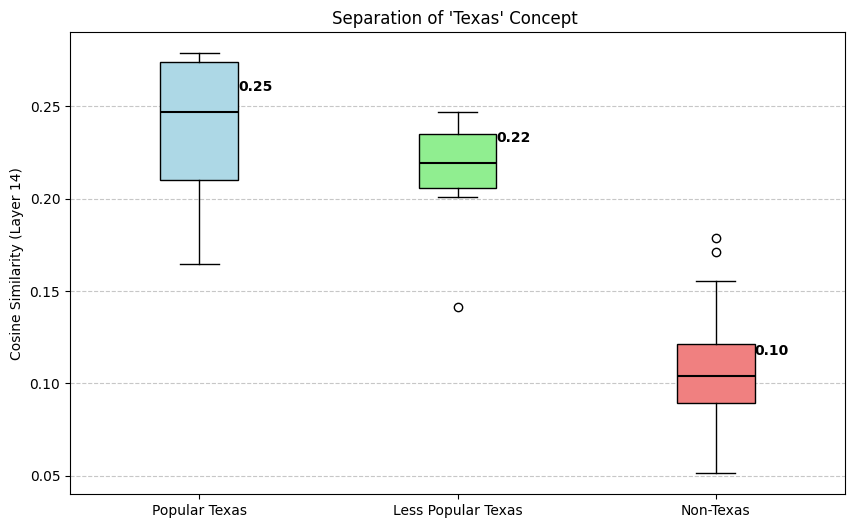

In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Data ---
city_clusters = {
    "Popular Texas": [
        "Houston", "San Antonio", "Dallas", "Austin", "Fort Worth", 
        "El Paso", "Arlington", "Corpus Christi", "Plano", "Laredo"
    ],
    "Less Popular Texas": [
        "Lubbock", "Amarillo", "Waco", "Odessa", "Tyler", 
        "Abilene", "Midland", "Beaumont", "Denton", "Killeen"
    ],
    "Non-Texas": [
        "New York", "Los Angeles", "Chicago", "Miami", "Seattle", 
        "Denver", "Boston", "Atlanta", "Detroit", "Phoenix", 
        "London", "Paris", "Tokyo", "Toronto", "Berlin", 
        "Madrid", "Rome", "Beijing", "Moscow", "Sydney", 
        "Cairo", "Mumbai", "Dubai", "Seoul", "Bangkok", 
        "Singapore", "Dublin", "Amsterdam", "Vienna", "Prague", 
        "Lisbon", "Oslo", "Stockholm", "Helsinki", "Copenhagen", 
        "Brussels", "Zurich", "Geneva", "Vancouver", "Montreal",
        "Philadelphia", "San Francisco", "Washington", "Las Vegas", "Portland",
        "Nashville", "New Orleans", "Orlando", "Cleveland", "Minneapolis"
    ]
}

def get_layer_14_similarity_fixed(city_name, model, feature_node):
    # 1. Setup Prompt
    prompt = f"The capital of the state containing {city_name} is"
    
    # 2. Get Texas Feature Direction (Layer 14)
    feat_obj = next((f for f in feature_node.features if f.layer == 14), None)
    if feat_obj is None: return 0.0
    
    idx_tensor = torch.tensor([feat_obj.feature_idx], device=model.cfg.device)
    sae_dir = model.transcoders._get_decoder_vectors(14, idx_tensor).flatten()

    # 3. Find the Token Index (String Matching Strategy)
    # We get the list of string tokens (e.g., ['The', ' capital', ..., ' Dal', 'las', ' is'])
    str_tokens = model.to_str_tokens(prompt)
    
    # We assume the prompt ALWAYS ends with "... {city} is" (or "... {city} is")
    # We want the token just before " is". 
    # This effectively grabs the last token of the city name.
    target_idx = -2 
    
    # Double check: Ensure the token at -1 is actually related to "is"
    if "is" not in str_tokens[-1]:
        # If 'is' is not the last token, we scan backwards to find it
        try:
            # Find the last occurrence of a token containing "is"
            target_idx = [i for i, t in enumerate(str_tokens) if "is" == t.strip()][-1] - 1
        except IndexError:
            # Fallback if 'is' isn't found (unlikely)
            target_idx = -2

    # 4. Run Model & Extract
    _, cache = model.run_with_cache(prompt, names_filter=lambda x: x == "blocks.14.hook_resid_post")
    city_vector = cache["blocks.14.hook_resid_post"][0, target_idx, :]

    # 5. Compute Similarity
    sim = F.cosine_similarity(city_vector.unsqueeze(0), sae_dir.unsqueeze(0)).item()
    return sim

# --- 2. Run Experiment ---
results = {}

print(f"Processing clusters...")
for cluster_name, cities in city_clusters.items():
    scores = []
    for city in cities:
        try:
            score = get_layer_14_similarity_fixed(city, model, texas_node)
            scores.append(score)
        except Exception as e:
            print(f"Error on {city}: {e}")
            scores.append(0.0)
    results[cluster_name] = scores
    print(f"Done: {cluster_name} (Avg: {np.mean(scores):.4f})")

# --- 3. Box Plot Visualization ---
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
data_to_plot = [results["Popular Texas"], results["Less Popular Texas"], results["Non-Texas"]]
labels = ["Popular Texas", "Less Popular Texas", "Non-Texas"]
colors = ['lightblue', 'lightgreen', 'lightcoral']

# Create Box Plot
bplot = plt.boxplot(data_to_plot, 
                    tick_labels=labels, 
                    patch_artist=True,  # fill with color
                    medianprops=dict(color="black", linewidth=1.5))

# Color the boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel("Cosine Similarity (Layer 14)")
plt.title("Separation of 'Texas' Concept ")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numeric annotations for medians
for i, line in enumerate(bplot['medians']):
    x, y = line.get_xydata()[1] # Right side of the median line
    plt.text(x, y + 0.01, f"{y:.2f}", horizontalalignment='left', verticalalignment='bottom', fontweight='bold')

plt.show()

###  Impact of 'Texas' Feature Ablation on Spelling Task on diverse cities

Running Popular Texas...


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Running Less Popular Texas...


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Running Non-Texas...


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


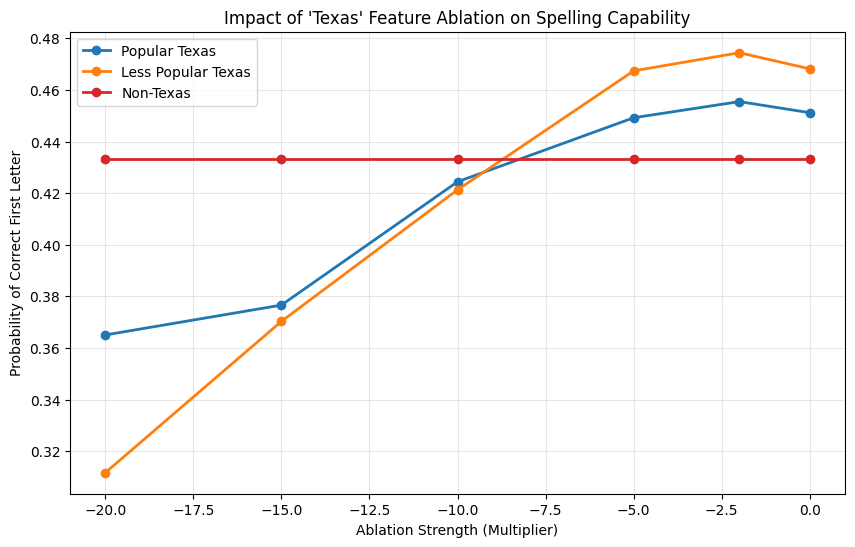

In [49]:
# --- 1. SETUP DATA ---
city_clusters = {
    "Popular Texas": [
        "Houston", "San Antonio", "Dallas", "Austin", "Fort Worth", 
        "El Paso", "Arlington", "Corpus Christi", "Plano", "Laredo"
    ],
    "Less Popular Texas": [
        "Lubbock", "Amarillo", "Waco", "Odessa", "Tyler", 
        "Abilene", "Midland", "Beaumont", "Denton", "Killeen"
    ],
    "Non-Texas": [
        "New York", "Chicago", "Seattle", "Denver", "Boston", 
        "London", "Paris", "Tokyo", "Berlin", "Rome",
        "Cairo", "Sydney", "Dubai", "Seoul", "Toronto"
    ]
}

alphas = [0, -2, -5, -10, -15, -20]

# --- 2. EXPERIMENT FUNCTION ---
def run_robust_experiment(word_list, alphas, label):
    results_alpha = {alpha: [] for alpha in alphas}
    
    # Pre-calculate feature indices (Layer, Idx) for the Texas Node
    texas_components = [(f.layer, f.feature_idx) for f in texas_node.features]

    print(f"Running {label}...")
    
    for word in tqdm(word_list):
        prompt = f"The first letter in the word {word} is"
        target_char = " " + word[0].upper()
        # Find token ID for the first letter (e.g., " D")
        target_id = model.tokenizer.encode(target_char, add_special_tokens=False)[0]
        
        # 1. Base Run (Get Activations)
        logits_base, activations_dict = model.get_activations(prompt)
        
        # Find word position (Fallback to -2 if simple search fails)
        tokens = model.tokenizer.encode(prompt)
        word_pos_idx = len(tokens) - 2 # Default position
        for i, t in enumerate(tokens):
             if i < 3: continue 
             decoded = model.tokenizer.decode([t]).strip()
             # Check if this token is part of the city name
             if decoded.lower() in word.lower() and len(decoded) > 1:
                 word_pos_idx = i
                 break

        # 2. Setup Temp Node for this specific position
        temp_features = [Feature(layer=l, pos=word_pos_idx, feature_idx=i) for l, i in texas_components]
        temp_node = Supernode("TempTexas", temp_features)
        
        # Initialize Graph to read base values correctly
        temp_graph = InterventionGraph([[temp_node]], prompt)
        temp_graph.initialize_node(temp_node, activations_dict)
        
        # 3. Loop Alphas (Ablation)
        for alpha in alphas:
            if alpha == 0:
                prob = logits_base[0, -1].softmax(-1)[target_id].item()
                results_alpha[alpha].append(prob)
                continue
                
            intervention_values = []
            if temp_node.default_activations is not None:
                for feature, base_val in zip(temp_node.features, temp_node.default_activations):
                    # SCALING: New = Alpha * Base. 
                    # If Base is 0 (Non-Texas city), this does nothing (Correct).
                    new_val = alpha * base_val 
                    intervention_values.append((*feature, new_val))
            
            if not intervention_values:
                 prob = logits_base[0, -1].softmax(-1)[target_id].item()
            else:
                 logits_new, _ = model.feature_intervention(prompt, intervention_values)
                 prob = logits_new[0, -1].softmax(-1)[target_id].item()
            
            results_alpha[alpha].append(prob)

    return [np.mean(results_alpha[a]) for a in alphas]

# --- 3. EXECUTE ---
results_data = {}
for cluster_name, cities in city_clusters.items():
    results_data[cluster_name] = run_robust_experiment(cities, alphas, cluster_name)

# --- 4. VISUALIZE ---
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#d62728'] # Blue, Orange, Red

for i, (label, probs) in enumerate(results_data.items()):
    plt.plot(alphas, probs, marker='o', linewidth=2, label=label, color=colors[i])



plt.title("Impact of 'Texas' Feature Ablation on Spelling Capability")
plt.xlabel("Ablation Strength (Multiplier)")
plt.ylabel("Probability of Correct First Letter")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 

## Result : Avtivation Strength vs Causal Necessity at layer 14 and layer 7

Running Dual-Layer Analysis...
Processing Popular Texas...


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Processing Less Popular Texas...


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Processing Non-Texas...


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


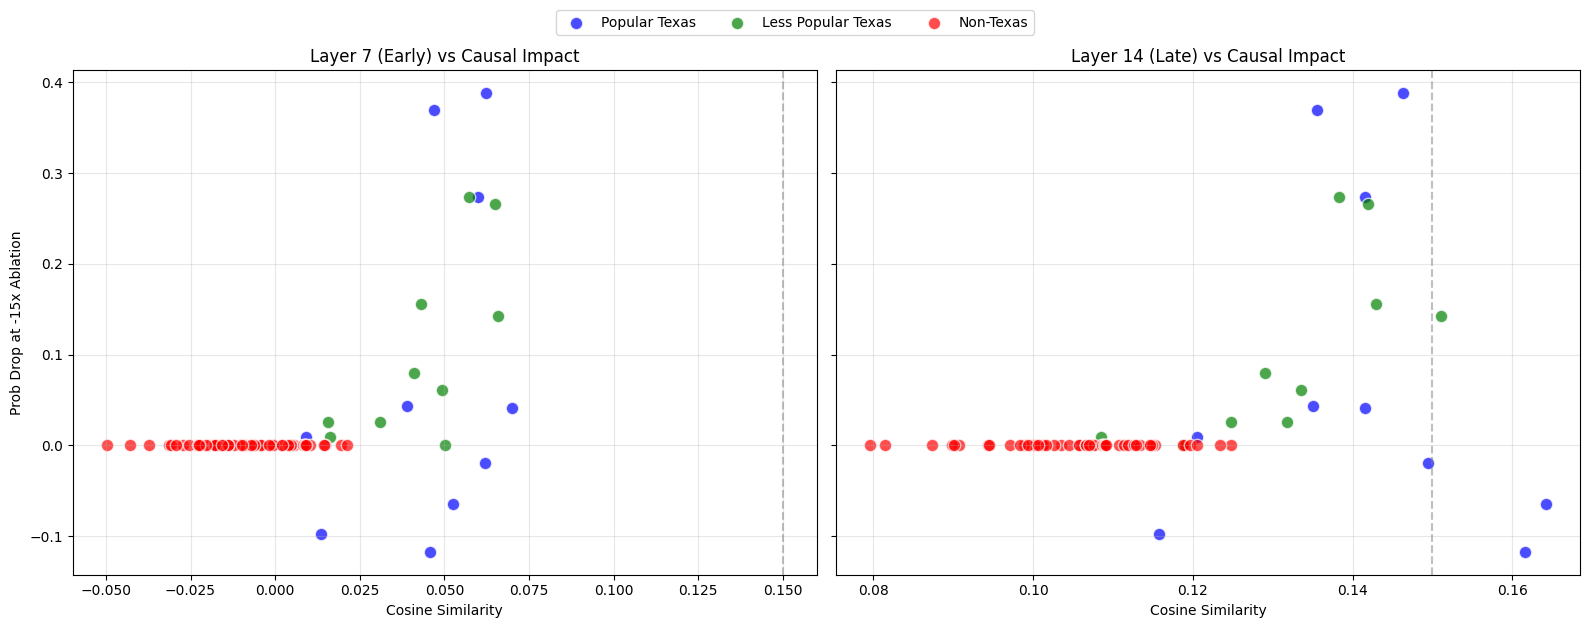

In [11]:
# --- 1. SETUP ---
SCALING_FACTOR = -15 

# Define Clusters
city_clusters = {
    "Popular Texas": [
        "Houston", "San Antonio", "Dallas", "Austin", "Fort Worth", 
        "El Paso", "Arlington", "Corpus Christi", "Plano", "Laredo"
    ],
    "Less Popular Texas": [
        "Lubbock", "Amarillo", "Waco", "Odessa", "Tyler", 
        "Abilene", "Midland", "Beaumont", "Denton", "Killeen"
    ],
    "Non-Texas": [
        "New York", "Los Angeles", "Chicago", "Miami", "Seattle", 
        "Denver", "Boston", "Atlanta", "Detroit", "Phoenix", 
        "London", "Paris", "Tokyo", "Toronto", "Berlin", 
        "Madrid", "Rome", "Beijing", "Moscow", "Sydney", 
        "Cairo", "Mumbai", "Dubai", "Seoul", "Bangkok", 
        "Singapore", "Dublin", "Amsterdam", "Vienna", "Prague", 
        "Lisbon", "Oslo", "Stockholm", "Helsinki", "Copenhagen", 
        "Brussels", "Zurich", "Geneva", "Vancouver", "Montreal",
        "Philadelphia", "San Francisco", "Washington", "Las Vegas", "Portland",
        "Nashville", "New Orleans", "Orlando", "Cleveland", "Minneapolis"
    ]
}


# Get Decoder Vectors for BOTH Layers
# Layer 14 (Feature 2268)
feat_l14 = next((f for f in texas_node.features if f.layer == 14), None)
idx_14 = torch.tensor([feat_l14.feature_idx], device=model.cfg.device)
sae_dir_l14 = model.transcoders._get_decoder_vectors(14, idx_14).flatten()

# Layer 7 (Feature 6861)
feat_l7 = next((f for f in texas_node.features if f.layer == 7), None)
idx_7 = torch.tensor([feat_l7.feature_idx], device=model.cfg.device)
sae_dir_l7 = model.transcoders._get_decoder_vectors(7, idx_7).flatten()

# --- 2. MODIFIED MEASUREMENT FUNCTION ---
def measure_city_stats_dual(city, model, feature_node):
    # A. Setup
    prompt = f"The first letter in the word {city} is"
    target_char = " " + city[0].upper()
    try:
        target_id = model.tokenizer.encode(target_char, add_special_tokens=False)[0]
    except:
        return None, None, None

    # B. GET COSINE SIMILARITY (Layer 7 AND 14)
    # Trace inputs to both layers
    str_tokens = model.to_str_tokens(prompt)
    pos_idx = -2 
    
    # We grab 'hook_resid_pre' because that is the input the SAE sees
    target_hooks = ["blocks.7.hook_resid_pre", "blocks.14.hook_resid_pre"]
    _, cache = model.run_with_cache(prompt, names_filter=lambda x: x in target_hooks)
    
    # Sim Layer 7
    vec_7 = cache["blocks.7.hook_resid_pre"][0, pos_idx, :]
    sim_7 = F.cosine_similarity(vec_7.unsqueeze(0), sae_dir_l7.unsqueeze(0)).item()
    
    # Sim Layer 14
    vec_14 = cache["blocks.14.hook_resid_pre"][0, pos_idx, :]
    sim_14 = F.cosine_similarity(vec_14.unsqueeze(0), sae_dir_l14.unsqueeze(0)).item()

    # C. GET PROBABILITY DROP (Ablating BOTH layers)
    # 1. Base Run
    logits_base, acts_dict = model.get_activations(prompt)
    base_prob = logits_base[0, -1].softmax(-1)[target_id].item()
    
    # 2. Build Intervention
    intervention_values = []
    
    # Iterate over features in the Supernode (which likely contains L7 and L14 features)
    for f in feature_node.features:
        # Robustly find base activation
        try:
            if isinstance(acts_dict, torch.Tensor):
                base_val = acts_dict[f.layer, pos_idx, f.feature_idx].item()
            else:
                base_val = acts_dict[f.layer, pos_idx, f.feature_idx].item()
        except:
            base_val = 0.0

        if base_val > 0.01:
            new_val = base_val * SCALING_FACTOR
            intervention_values.append((f.layer, pos_idx, f.feature_idx, new_val))

    # 3. Ablated Run
    if not intervention_values:
        prob_drop = 0.0
    else:
        logits_new, _ = model.feature_intervention(prompt, intervention_values)
        ablated_prob = logits_new[0, -1].softmax(-1)[target_id].item()
        prob_drop = base_prob - ablated_prob
    
    return sim_7, sim_14, prob_drop

# --- 3. RUN LOOP ---
plot_data = {"x7": [], "x14": [], "y": [], "c": [], "label": []}
colors = {"Popular Texas": "blue", "Less Popular Texas": "green", "Non-Texas": "red"}

print("Running Dual-Layer Analysis...")
for cluster, cities in city_clusters.items():
    print(f"Processing {cluster}...")
    for city in tqdm(cities):
        s7, s14, drop = measure_city_stats_dual(city, model, texas_node)
        if s7 is not None:
            plot_data["x7"].append(s7)
            plot_data["x14"].append(s14)
            plot_data["y"].append(drop)
            plot_data["c"].append(colors[cluster])
            plot_data["label"].append(cluster)

# --- 4. DUAL PLOT ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Helper to plot on a specific axis
def scatter_on_ax(ax, x_key, title):
    groups_plotted = set()
    for x, y, c, l in zip(plot_data[x_key], plot_data["y"], plot_data["c"], plot_data["label"]):
        if l not in groups_plotted:
            ax.scatter(x, y, color=c, s=80, alpha=0.7, label=l, edgecolors='white')
            groups_plotted.add(l)
        else:
            ax.scatter(x, y, color=c, s=80, alpha=0.7, edgecolors='white')
    
    ax.set_xlabel("Cosine Similarity")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.axvline(0.15, color='gray', linestyle='--', alpha=0.5)

# Plot Left (Layer 7)
scatter_on_ax(ax1, "x7", "Layer 7 (Early) vs Causal Impact")
ax1.set_ylabel(f"Prob Drop at {SCALING_FACTOR}x Ablation")

# Plot Right (Layer 14)
scatter_on_ax(ax2, "x14", "Layer 14 (Late) vs Causal Impact")

# Single Legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()
plt.show()

## Comparison of Injection on Chicago and Paris

In [12]:
# --- 1. Experiment Setup ---
targets = ["Chicago", "Paris"]
alphas = range(0, 100, 10) # 0 to 90
prompt_template = "The city of {} is located in the state of"

# 2. Get Layer 14 Feature (Assumes texas_node is defined from previous steps)
texas_feat_14 = next((f for f in texas_node.features if f.layer == 14), None)
if not texas_feat_14:
    # Fallback to manual ID if node object isn't active
    class MockFeat: pass
    texas_feat_14 = MockFeat()
    texas_feat_14.layer = 14
    texas_feat_14.feature_idx = 2268 
    print("Warning: Using default Feature 2268")

print(f"Injecting Feature L{texas_feat_14.layer}_{texas_feat_14.feature_idx} (Texas)...")
print("-" * 75)
print(f"{'Alpha':<6} | {'Chicago Pred':<15} | {'Prob':<8} || {'Paris Pred':<15} | {'Prob':<8}")
print("-" * 75)

# --- 3. Comparison Loop ---
# We collect data first to print row-by-row
results = {alpha: {} for alpha in alphas}

for city in targets:
    prompt = prompt_template.format(city)
    
    # Robust Token Search
    str_tokens = model.to_str_tokens(prompt)
    try:
        # Best Heuristic: Find the token immediately before " is"
        # This reliably targets the last token of the city name
        subj_idx = next(i for i, t in enumerate(str_tokens) if " is" in t) - 1
    except StopIteration:
        # Fallback: Search for city name directly
        subj_idx = next((i for i, t in enumerate(str_tokens) if city in t), -1)
        
    if subj_idx == -1:
        print(f"Error: Could not find token for {city}")
        continue

    for alpha in alphas:
        # Intervention
        intervention = [(14, subj_idx, texas_feat_14.feature_idx, float(alpha))]
        
        # Run Model
        logits, _ = model.feature_intervention(prompt, intervention)
        
        # Decode Output
        probs = logits[0, -1].softmax(dim=-1)
        top_id = probs.argmax().item()
        top_token = model.tokenizer.decode([top_id]).strip()
        top_prob = probs[top_id].item()
        
        results[alpha][city] = (top_token, top_prob)

# --- 4. Print Table ---
for alpha in alphas:
    c_pred, c_prob = results[alpha]["Chicago"]
    p_pred, p_prob = results[alpha]["Paris"]
    
    # Highlight "Texas" success visually
    c_str = f"{c_pred} ({c_prob:.0%})"
    p_str = f"{p_pred} ({p_prob:.0%})"
    
    if "Texas" in c_pred: c_str = f"[*] {c_str}"
    if "Texas" in p_pred: p_str = f"[*] {p_str}"
    
    print(f"{alpha:<6} | {c_str:<25} || {p_str:<25}")

Injecting Feature L14_2268 (Texas)...
---------------------------------------------------------------------------
Alpha  | Chicago Pred    | Prob     || Paris Pred      | Prob    
---------------------------------------------------------------------------
0      | Illinois (97%)            || France (17%)             
10     | Illinois (96%)            || France (18%)             
20     | Illinois (97%)            || France (16%)             
30     | Illinois (96%)            || [*] Texas (18%)          
40     | Illinois (96%)            || [*] Texas (24%)          
50     | Illinois (93%)            || [*] Texas (29%)          
60     | Illinois (88%)            || [*] Texas (36%)          
70     | Illinois (72%)            || [*] Texas (41%)          
80     | Illinois (54%)            || [*] Texas (47%)          
90     | [*] Texas (57%)           || [*] Texas (47%)          


## Attribute Lens to test Polysemanticity

In [15]:
def interpret_feature_projection(model, layer_idx, feature_idx, top_k=10):
    # 1. Get the SAE Decoder Vector (Feature Direction)
    # This is the vector the SAE adds to the residual stream when active
    idx_tensor = torch.tensor([feature_idx], device=model.cfg.device)
    feature_vector = model.transcoders._get_decoder_vectors(layer_idx, idx_tensor)
    # Shape: [1, d_model]

    # 2. Project into Vocabulary Space (Unembedding)
    # Multiply by the Unembedding Matrix (W_U)
    # W_U shape is usually [d_model, vocab_size]
    # We use the internal 'unembed' module or W_U directly
    logits = model.unembed(feature_vector) 
    # Shape: [1, vocab_size]

    # 3. Sort and Print Top Tokens
    probs = logits.softmax(dim=-1)
    top_probs, top_ids = torch.topk(probs, k=top_k)
    
    print(f"--- Top {top_k} Tokens promoted by Layer {layer_idx} Feature {feature_idx} ---")
    print(f"{'Token':<15} | {'Probability':<12}")
    print("-" * 30)
    
    for i in range(top_k):
        token_id = top_ids[0, i].item()
        token_str = model.tokenizer.decode([token_id])
        prob = top_probs[0, i].item()
        print(f"{token_str:<15} | {prob:.4%}")

# --- Run Analysis ---
interpret_feature_projection(model, layer_idx=14, feature_idx=2268)
interpret_feature_projection(model, layer_idx=7, feature_idx=6861)


--- Top 10 Tokens promoted by Layer 14 Feature 2268 ---
Token           | Probability 
------------------------------
 Texas          | 0.0005%
 Texan          | 0.0005%
Texas           | 0.0005%
 Texans         | 0.0005%
 Dallas         | 0.0005%
 Houston        | 0.0005%
 texas          | 0.0005%
Dallas          | 0.0005%
Houston         | 0.0005%
 TX             | 0.0005%
--- Top 10 Tokens promoted by Layer 7 Feature 6861 ---
Token           | Probability 
------------------------------
ⓧ               | 0.0005%
PyExc           | 0.0005%
".$_            | 0.0005%
bootstrapcdn    | 0.0005%
stdafx          | 0.0005%
pyx             | 0.0005%
Hentet          | 0.0005%
 AssemblyCulture | 0.0005%
 Texan          | 0.0005%
 Texas          | 0.0005%


## Feature splitting experiments

### 1. Ablation of Texas for Houston on layer 14

In [10]:

# 1. Setup
prompt = "The city of Houston is located in the state of"
alphas = [0, -10, -20, -50, -100] # 0 is the baseline

# 2. Identify Target Feature and Position
layer_idx = 14
feature_idx = 2268

# Find the position of "Houston"
# "The city of [Houston] is..."
str_tokens = model.to_str_tokens(prompt)
try:
    # Find the token containing "Houston"
    subj_idx = next(i for i, t in enumerate(str_tokens) if "Houston" in t)
    print(f"Targeting token '{str_tokens[subj_idx]}' at index {subj_idx}")
except StopIteration:
    subj_idx = 3 # Fallback based on standard tokenization
    print(f"Warning: Token not found, using index {subj_idx}")

print(f"{'Alpha':<10} | {'Prediction':<15} | {'Prob':<10}")
print("-" * 45)

# 3. Run Ablation Loop
for alpha in alphas:
    # Construct Intervention: (Layer, Position, Feature, Value)
    # Applying a negative value acts as an ablation/suppression
    # Note: We usually multiply the existing activation by alpha, 
    # but the API typically expects a specific value to set or add.
    # If the API adds: adding a large negative cancels it out.
    # If the API sets: we need to know the base value.
    # Assuming 'feature_intervention' performs: feat = feat + value (or similar steering)
    # A safe bet for ablation with this library is often providing a large negative multiplier 
    # if the library supports scaling, OR simply setting a large negative if it's additive.
    
    # Based on previous context, we treat alpha as a steering vector scalar.
    intervention = [(layer_idx, subj_idx, feature_idx, float(alpha))]
    
    # Run
    logits, _ = model.feature_intervention(prompt, intervention)
    
    # Decode
    probs = logits[0, -1].softmax(dim=-1)
    top_id = probs.argmax().item()
    top_token = model.tokenizer.decode([top_id]).strip()
    top_prob = probs[top_id].item()
    
    print(f"{alpha:<10} | {top_token:<15} | {top_prob:.2%}")

Targeting token ' Houston' at index 4
Alpha      | Prediction      | Prob      
---------------------------------------------
0          | Texas           | 96.09%
-10        | Texas           | 95.70%
-20        | Texas           | 94.53%
-50        | Texas           | 78.12%
-100       | New             | 30.47%


### 2. Ablation of Texason Houston on layer 14 and layer 7

In [11]:
# 1. Setup
prompt = "The city of Houston is located in the state of"
alphas = [0, -10, -20, -50, -100] # Negative alphas to suppress the features

# 2. Define Targets
targets = [
    {"layer": 14, "feature": 2268}, # Main Texas feature
    {"layer": 7,  "feature": 6861}  # Early supporting feature
]

# 3. Find Target Token ("Houston")
str_tokens = model.to_str_tokens(prompt)
try:
    subj_idx = next(i for i, t in enumerate(str_tokens) if "Houston" in t)
    print(f"Targeting token '{str_tokens[subj_idx]}' at index {subj_idx}")
except StopIteration:
    subj_idx = 3 # Fallback
    print(f"Warning: 'Houston' not found. Using fallback index {subj_idx}")

print("-" * 55)
print(f"{'Alpha':<10} | {'Prediction':<15} | {'Prob':<10} | {'Status'}")

# 4. Multi-Layer Ablation Loop
for alpha in alphas:
    # Build list of interventions for this alpha
    interventions = []
    for t in targets:
        # (Layer, Position, Feature, Value)
        interventions.append((t["layer"], subj_idx, t["feature"], float(alpha)))
    
    # Run Model with BOTH interventions active
    logits, _ = model.feature_intervention(prompt, interventions)
    
    # Decode Result
    probs = logits[0, -1].softmax(dim=-1)
    top_id = probs.argmax().item()
    top_token = model.tokenizer.decode([top_id]).strip()
    top_prob = probs[top_id].item()
    
    # Check if Texas was successfully removed
    status = "SUPPRESSED" if "Texas" not in top_token and alpha != 0 else "ACTIVE"
    if alpha == 0: status = "BASELINE"

    print(f"{alpha:<10} | {top_token:<15} | {top_prob:.2%} | {status}")

Targeting token ' Houston' at index 4
-------------------------------------------------------
Alpha      | Prediction      | Prob       | Status
0          | Texas           | 96.48% | BASELINE
-10        | Texas           | 93.75% | ACTIVE
-20        | Texas           | 87.11% | ACTIVE
-50        | New             | 28.12% | SUPPRESSED
-100       | New             | 60.94% | SUPPRESSED


### 3. Injection of Texas feature on Chicago in Layer 7 and Layer 14

In [18]:


# 1. Setup
prompt = "The city of Chicago is located in the state of"
alphas = [0, 10, 20, 50, 100] # Negative alphas to suppress the features

# 2. Define Targets
targets = [
    {"layer": 14, "feature": 2268}, # Main Texas feature
    {"layer": 7,  "feature": 6861}  # Early supporting feature
]

# 3. Find Target Token ("Houston")
str_tokens = model.to_str_tokens(prompt)
try:
    subj_idx = next(i for i, t in enumerate(str_tokens) if "Chicago" in t)
    print(f"Targeting token '{str_tokens[subj_idx]}' at index {subj_idx}")
except StopIteration:
    subj_idx = 3 # Fallback
    print(f"Warning: 'Chicago' not found. Using fallback index {subj_idx}")

print("-" * 55)
print(f"{'Alpha':<10} | {'Prediction':<15} | {'Prob':<10} | {'Status'}")

# 4. Multi-Layer Ablation Loop
for alpha in alphas:
    # Build list of interventions for this alpha
    interventions = []
    for t in targets:
        # (Layer, Position, Feature, Value)
        interventions.append((t["layer"], subj_idx, t["feature"], float(alpha)))
    
    # Run Model with BOTH interventions active
    logits, _ = model.feature_intervention(prompt, interventions)
    
    # Decode Result
    probs = logits[0, -1].softmax(dim=-1)
    top_id = probs.argmax().item()
    top_token = model.tokenizer.decode([top_id]).strip()
    top_prob = probs[top_id].item()
    
    # Check if Texas was successfully removed
    status = "SUPPRESSED" if "Texas" not in top_token and alpha != 0 else "ACTIVE"
    if alpha == 0: status = "BASELINE"

    print(f"{alpha:<10} | {top_token:<15} | {top_prob:.2%} | {status}")

Targeting token ' Chicago' at index 4
-------------------------------------------------------
Alpha      | Prediction      | Prob       | Status
0          | Illinois        | 96.88% | BASELINE
10         | Illinois        | 96.88% | SUPPRESSED
20         | Illinois        | 95.31% | SUPPRESSED
50         | Texas           | 71.09% | ACTIVE
100        | Texas           | 93.36% | ACTIVE


### 4. Composibility Test

In [14]:

# 1. Setup
base_prompt = "The capital city of the state of"
alphas = [0, 20, 50, 80, 150]

print(f"Prompt: '{base_prompt}'")
print(f"Injecting L7_6861 AND L14_2268 at the token 'of'...\n")
print(f"{'Alpha':<8} | {'Generated Sequence (3 Tokens)':<35}")
print("-" * 60)

# 2. Experiment Loop
for alpha in alphas:
    curr_prompt = base_prompt
    generated_tokens = []
    
    # Generate 3 tokens one by one
    for step in range(3):
        # Inject ONLY at the first step (the "spark")
        if step == 0:
            intervention = [
                (7, -1, 6861, float(alpha)),  # Early Layer Injection
                (14, -1, 2268, float(alpha))  # Middle Layer Injection
            ]
        else:
            intervention = [] # Let the model run naturally after the spark

        # Run Model
        if intervention:
            logits, _ = model.feature_intervention(curr_prompt, intervention)
        else:
            logits = model(curr_prompt)
        
        # Greedy Decode
        probs = logits[0, -1].softmax(dim=-1)
        top_id = probs.argmax().item()
        top_token = model.tokenizer.decode([top_id])
        
        generated_tokens.append(top_token)
        curr_prompt += top_token

    # 3. Output
    full_sequence = "".join(generated_tokens).replace("\n", "\\n")
    print(f"{alpha:<8} | {full_sequence:<35}")

Prompt: 'The capital city of the state of'
Injecting L7_6861 AND L14_2268 at the token 'of'...

Alpha    | Generated Sequence (3 Tokens)      
------------------------------------------------------------
0        |  New York,                         
20       |  New York,                         
50       |  Texas, Austin                     
80       |  Texas, Austin                     
150      |  Texas, Austin                     


## Result : LRE experiment for 50 cities in Texas

Analyzing 50 Texas cities...


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


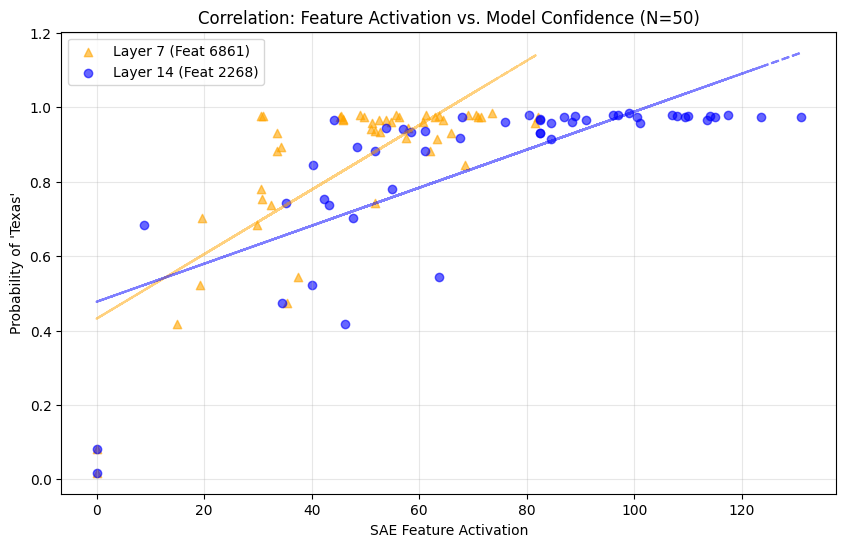

In [16]:
# --- 1. Dataset: 50 Texas Cities ---
texas_cities = [
    # Major Metros & Independent Hubs
    "Houston", "Dallas", "San Antonio", "Austin", "El Paso", 
    "Corpus Christi", "Lubbock", "Laredo", "Amarillo", "Brownsville", 
    "Odessa", "Midland", "Abilene", "Wichita Falls", "Beaumont", 
    "Waco", "San Angelo", "Galveston", "McAllen", "Texarkana",
    
    # East Texas / Piney Woods
    "Tyler", "Longview", "Marshall", "Lufkin", "Nacogdoches", "Paris", "Palestine",
    
    # Central / Hill Country
    "Killeen", "Temple", "College Station", "Bryan", "San Marcos", 
    "New Braunfels", "Kerrville", "Fredericksburg",
    
    # South / Border / Coastal
    "Harlingen", "Victoria", "Edinburg", "Mission", "Pharr", 
    "Del Rio", "Eagle Pass", "Kingsville", "Alice",
    
    # North / Panhandle / West
    "Sherman", "Denison", "Gainesville", "Big Spring", "Stephenville", "Sweetwater"
]



# --- 2. Measurement Function ---
def measure_features_and_prob(city, model):
    prompt = f"The city of {city} is located in the state of"
    
    # Run Cache to get inputs for Layer 7 and 14
    # We need 'hook_resid_pre' for both layers to feed the SAEs
    _, cache = model.run_with_cache(prompt, names_filter=lambda x: x.endswith("hook_resid_pre"))
    
    # Find position of the city (Last token of the subject)
    # Heuristic: Find " is" and go back 1 token
    str_tokens = model.to_str_tokens(prompt)
    try:
        pos_idx = next(i for i, t in enumerate(str_tokens) if " is" in t) - 1
    except:
        pos_idx = -2 # Fallback
        
    # --- Measure Layer 7 Feature 6861 ---
    vec_l7 = cache["blocks.7.hook_resid_pre"][0, pos_idx, :]
    # Encode and extract feature 6861
    acts_l7 = model.transcoders[7].encode(vec_l7.unsqueeze(0))
    val_l7 = acts_l7[0, 6861].item()
    
    # --- Measure Layer 14 Feature 2268 ---
    vec_l14 = cache["blocks.14.hook_resid_pre"][0, pos_idx, :]
    # Encode and extract feature 2268
    acts_l14 = model.transcoders[14].encode(vec_l14.unsqueeze(0))
    val_l14 = acts_l14[0, 2268].item()
    
    # --- Measure Output Probability ---
    logits = model(prompt)
    probs = logits[0, -1].softmax(dim=-1)
    texas_id = model.tokenizer.encode(" Texas", add_special_tokens=False)[0]
    prob_texas = probs[texas_id].item()
    
    return val_l7, val_l14, prob_texas

# --- 3. Run Loop ---
results = {"L7": [], "L14": [], "Prob": [], "City": []}

print("Analyzing 50 Texas cities...")
for city in tqdm(texas_cities):
    l7, l14, prob = measure_features_and_prob(city, model)
    results["L7"].append(l7)
    results["L14"].append(l14)
    results["Prob"].append(prob)
    results["City"].append(city)

# --- 4. Plotting ---
plt.figure(figsize=(10, 6))

# Plot Layer 7 Data
plt.scatter(results["L7"], results["Prob"], color='orange', alpha=0.6, label='Layer 7 (Feat 6861)', marker='^')

# Plot Layer 14 Data
plt.scatter(results["L14"], results["Prob"], color='blue', alpha=0.6, label='Layer 14 (Feat 2268)', marker='o')

# Trend Lines (Optional Simple Fit)
z7 = np.polyfit(results["L7"], results["Prob"], 1)
p7 = np.poly1d(z7)
plt.plot(results["L7"], p7(results["L7"]), "orange", linestyle="--", alpha=0.5)

z14 = np.polyfit(results["L14"], results["Prob"], 1)
p14 = np.poly1d(z14)
plt.plot(results["L14"], p14(results["L14"]), "blue", linestyle="--", alpha=0.5)

plt.xlabel("SAE Feature Activation")
plt.ylabel("Probability of 'Texas'")
plt.title("Correlation: Feature Activation vs. Model Confidence (N=50)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:

# 1. Convert Data to Arrays
l7_acts = np.array(results["L7"])
l14_acts = np.array(results["L14"])
probs = np.array(results["Prob"])

# 2. Calculate Pearson Correlation (r-value)
# Returns a matrix [[1.0, r], [r, 1.0]], we take [0, 1]
corr_l7 = np.corrcoef(l7_acts, probs)[0, 1]
corr_l14 = np.corrcoef(l14_acts, probs)[0, 1]

print("-" * 30)
print(f"Statistical Analysis (N=50)")
print("-" * 30)
print(f"Layer 7 (Feat 6861) Correlation:  {corr_l7:.4f}")
print(f"Layer 14 (Feat 2268) Correlation: {corr_l14:.4f}")


------------------------------
Statistical Analysis (N=50)
------------------------------
Layer 7 (Feat 6861) Correlation:  0.7529
Layer 14 (Feat 2268) Correlation: 0.7429


## Result: The 'state' subspace experiment

Identifying State Features...
--- Layer 7 ---
  Texas: Feature 6861
  California: Feature 16323
  New York: Feature 8765
  Florida: Feature 12442
  Illinois: Feature 4594
  Ohio: Feature 14075
--- Layer 14 ---
  Texas: Feature 2268
  California: Feature 12562
  New York: Feature 3951
  Florida: Feature 8632
  Illinois: Feature 16323
  Ohio: Feature 6585


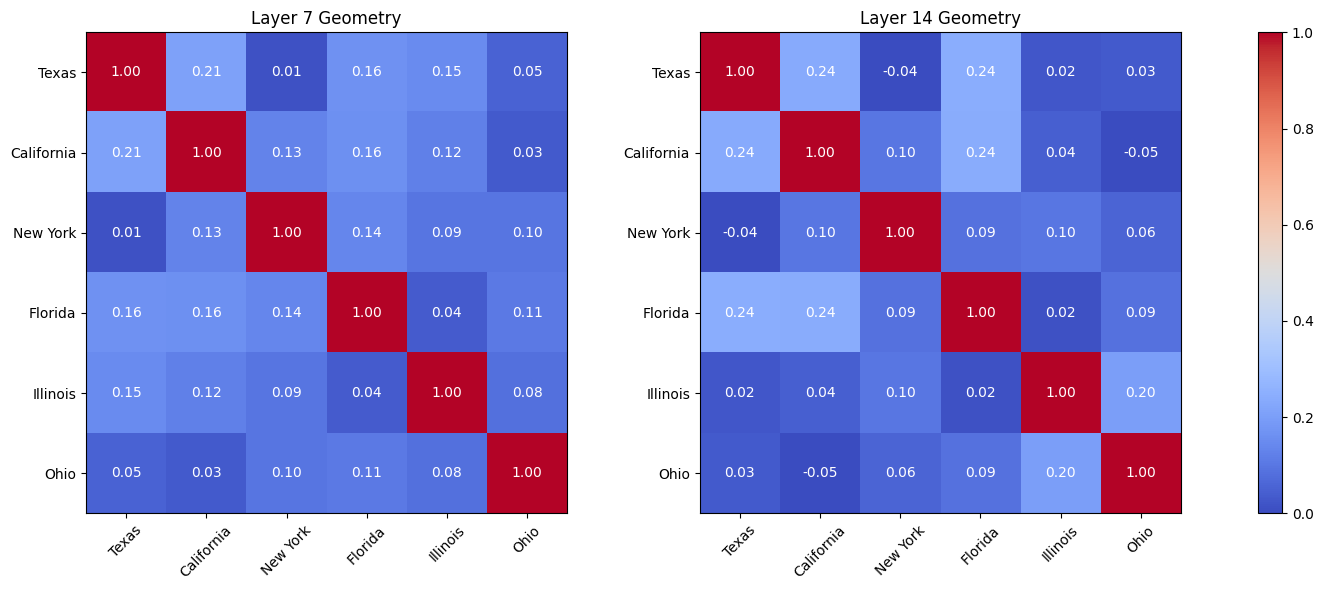

In [24]:


# --- 1. Dataset ---
state_targets = {
    "Texas":      {"cities": ["Houston", "Dallas", "Austin"], "token": " Texas"},
    "California": {"cities": ["Los Angeles", "San Francisco", "San Diego"], "token": " California"},
    "New York":   {"cities": ["New York", "Buffalo", "Rochester"], "token": " York"}, 
    "Florida":    {"cities": ["Miami", "Orlando", "Tampa"], "token": " Florida"},
    "Illinois":   {"cities": ["Chicago", "Aurora", "Joliet"], "token": " Illinois"},
    "Ohio":       {"cities": ["Columbus", "Cleveland", "Cincinnati"], "token": " Ohio"}
}

# --- 2. Scanner Function (Same as before) ---
def find_faithful_state_feature(state, data, layer_idx, model):
    target_token = data["token"]
    cities = data["cities"]
    target_id = model.tokenizer.encode(target_token, add_special_tokens=False)[0]
    
    candidate_scores = {}
    
    # print(f"  Scanning {state} @ L{layer_idx}...")
    
    for city in cities:
        prompt = f"The city of {city} is in the state of"
        
        # Get Inputs
        _, cache = model.run_with_cache(prompt, names_filter=lambda x: x == f"blocks.{layer_idx}.hook_resid_post")
        
        # Find position
        str_tokens = model.to_str_tokens(prompt)
        try:
            pos_idx = next(i for i, t in enumerate(str_tokens) if " is" in t) - 1
        except:
            print(f"Proper token position is not picked for the {city}")
            pos_idx = -2

        vec = cache[f"blocks.{layer_idx}.hook_resid_post"][0, pos_idx, :]
        encoded = model.transcoders[layer_idx].encode(vec.unsqueeze(0)).squeeze()
        
        # Top 20 candidates
        top_vals, top_inds = torch.topk(encoded, k=20)
        
        for idx in top_inds:
            feat_id = idx.item()
            
            # Project to Vocab
            idx_tensor = torch.tensor([feat_id], device=model.cfg.device)
            decoder_vec = model.transcoders._get_decoder_vectors(layer_idx, idx_tensor)
            feature_logits = model.unembed(decoder_vec).squeeze()
            
            state_logit = feature_logits[target_id].item()
            is_top_1 = (feature_logits.argmax().item() == target_id)
            
            if feat_id not in candidate_scores:
                candidate_scores[feat_id] = {"score": 0.0, "is_top_1": False}
            
            candidate_scores[feat_id]["score"] += state_logit
            if is_top_1: candidate_scores[feat_id]["is_top_1"] = True

    # Select Best
    best_feat = None
    best_score = -float('inf')
    
    for feat_id, stats in candidate_scores.items():
        if stats["score"] > best_score:
            best_score = stats["score"]
            best_feat = feat_id
            
    return best_feat

# --- 3. Run Both Layers ---
layers_to_scan = [7, 14]
results = {7: {}, 14: {}}

print("Identifying State Features...")
for layer in layers_to_scan:
    print(f"--- Layer {layer} ---")
    for state, data in state_targets.items():
        feat_id = find_faithful_state_feature(state, data, layer, model)
        results[layer][state] = feat_id
        print(f"  {state}: Feature {feat_id}")

# --- 4. Plotting Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, layer in enumerate(layers_to_scan):
    # Prepare Vectors
    vectors = []
    labels = []
    
    for state, feat_id in results[layer].items():
        # Extract Vector
        idx_tensor = torch.tensor([feat_id], device=model.cfg.device)
        vec = model.transcoders._get_decoder_vectors(layer, idx_tensor).flatten()
        vectors.append(vec)
        labels.append(state)
        
    # Similarity Matrix
    vec_stack = torch.stack(vectors)
    vec_norm = F.normalize(vec_stack, p=2, dim=1)
    sim_matrix = torch.mm(vec_norm, vec_norm.T).detach().float().cpu().numpy()
    
    # Plot
    im = axes[idx].imshow(sim_matrix, cmap='coolwarm', vmin=0, vmax=1)
    axes[idx].set_title(f"Layer {layer} Geometry")
    
    # Ticks
    axes[idx].set_xticks(range(len(labels)))
    axes[idx].set_xticklabels(labels, rotation=45)
    axes[idx].set_yticks(range(len(labels)))
    axes[idx].set_yticklabels(labels)
    
    # Annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = sim_matrix[i, j]
            color = "white" if (val < 0.4 or val > 0.8) else "black"
            axes[idx].text(j, i, f"{val:.2f}", ha="center", va="center", color=color)

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

## Result:  Depth-Dependent Causal Steering

Locating California Feature for Layer 14...
Features Ready: TX(L7=6861, L14=2268) | CA(L7=16323, L14=12562)

Running Comparison (Alpha=130(L7) and Alpha = 70(L14), N=20)...


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


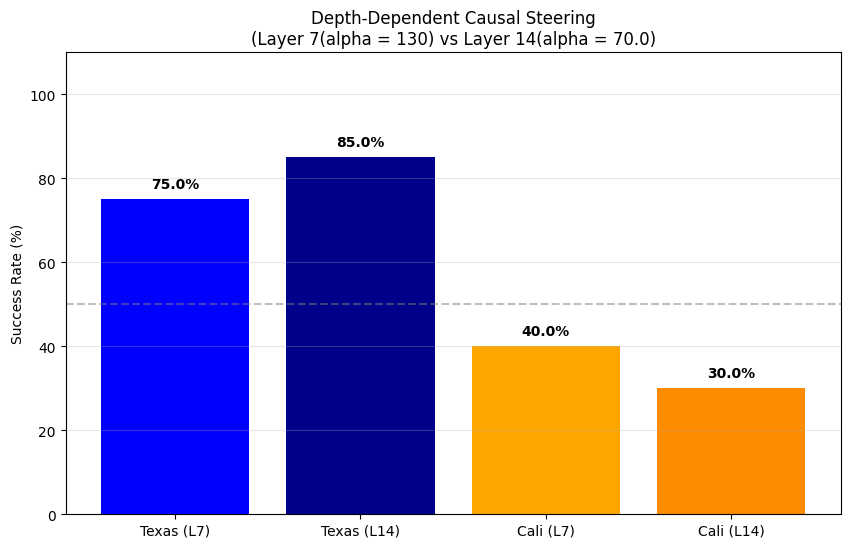


Detailed Scorecard:
{'Texas (L7)': 15, 'Texas (L14)': 17, 'Cali (L7)': 8, 'Cali (L14)': 6}


In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# --- 1. Dataset ---
ambiguous_inputs = [
    "Paris", "London", "Athens", "Dublin", "Moscow", 
    "Pittsburg", "Victoria", "Columbus", "Springfield", "Tyler", 
    "Palestine", "Florence", "Edinburg", "Manchester", "Wellington", 
    "Cleveland", "Atlanta", "Nevada", "Pasadena", "Miami"
]
 

# --- 2. Setup Features ---
# Texas Features (Known)
feat_tx_l7 = 6861
feat_tx_l14 = 2268

# California Features (L7 Known, L14 Dynamic Search)
feat_ca_l7 = 16323

print("Locating California Feature for Layer 14...")
def find_cali_l14(model):
    # Quick scan: Find feature that maximizes " California" output
    prompt = "The state of California" # Prototype
    _, cache = model.run_with_cache(prompt, names_filter=lambda x: x == "blocks.14.hook_resid_pre")
    vec = cache["blocks.14.hook_resid_pre"][0, -1, :]
    encoded = model.transcoders[14].encode(vec.unsqueeze(0)).squeeze()
    
    # Check top 10 active features
    top_inds = encoded.topk(10).indices
    best_f = -1
    best_s = -99
    
    cali_id = model.tokenizer.encode(" California", add_special_tokens=False)[0]
    
    for idx in top_inds:
        f_id = idx.item()
        # Decode
        idx_t = torch.tensor([f_id], device=model.cfg.device)
        dec = model.transcoders._get_decoder_vectors(14, idx_t)
        logits = model.unembed(dec).squeeze()
        if logits[cali_id] > best_s:
            best_s = logits[cali_id]
            best_f = f_id
    return best_f

feat_ca_l14 = find_cali_l14(model)
print(f"Features Ready: TX(L7={feat_tx_l7}, L14={feat_tx_l14}) | CA(L7={feat_ca_l7}, L14={feat_ca_l14})")

# --- 3. Experiment Function ---
def check_flip(city, layer, feat_id, target_str, alpha):
    prompt = f"The city of {city} is located in the state of"
    str_tokens = model.to_str_tokens(prompt)
    try:
        subj_idx = next(i for i, t in enumerate(str_tokens) if " is" in t) - 1
    except:
        subj_idx = -2

    # Injection (Alpha 130)
    intervention = [(layer, subj_idx, feat_id, alpha)]
    logits, _ = model.feature_intervention(prompt, intervention)
    
    top_token = model.tokenizer.decode([logits[0, -1].argmax()]).strip()
    return target_str in top_token

# --- 4. Run 4-Way Comparison ---
results = {
    "Texas (L7)": 0, "Texas (L14)": 0,
    "Cali (L7)": 0,  "Cali (L14)": 0
}

print(f"\nRunning Comparison (Alpha=130(L7) and Alpha = 70(L14), N={len(ambiguous_inputs)})...")

for city in tqdm(ambiguous_inputs):
    # Texas L7 vs L14
    if check_flip(city, 7, feat_tx_l7, "Texas", 130.0): results["Texas (L7)"] += 1
    if check_flip(city, 14, feat_tx_l14, "Texas", 70.0): results["Texas (L14)"] += 1
    
    # Cali L7 vs L14
    if check_flip(city, 7, feat_ca_l7, "California", 130.0): results["Cali (L7)"] += 1
    if check_flip(city, 14, feat_ca_l14, "California", 70.0): results["Cali (L14)"] += 1

# --- 5. Visualization ---
labels = list(results.keys())
counts = list(results.values())
percentages = [c / len(ambiguous_inputs) * 100 for c in counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, percentages, color=['blue', 'darkblue', 'orange', 'darkorange'])

# Formatting
plt.ylabel("Success Rate (%)")
plt.title("Depth-Dependent Causal Steering\n(Layer 7(alpha = 130) vs Layer 14(alpha = 70.0)")
plt.ylim(0, 110)
plt.axhline(50, color='gray', linestyle='--', alpha=0.5, label='Random Chance')

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nDetailed Scorecard:")
print(results)